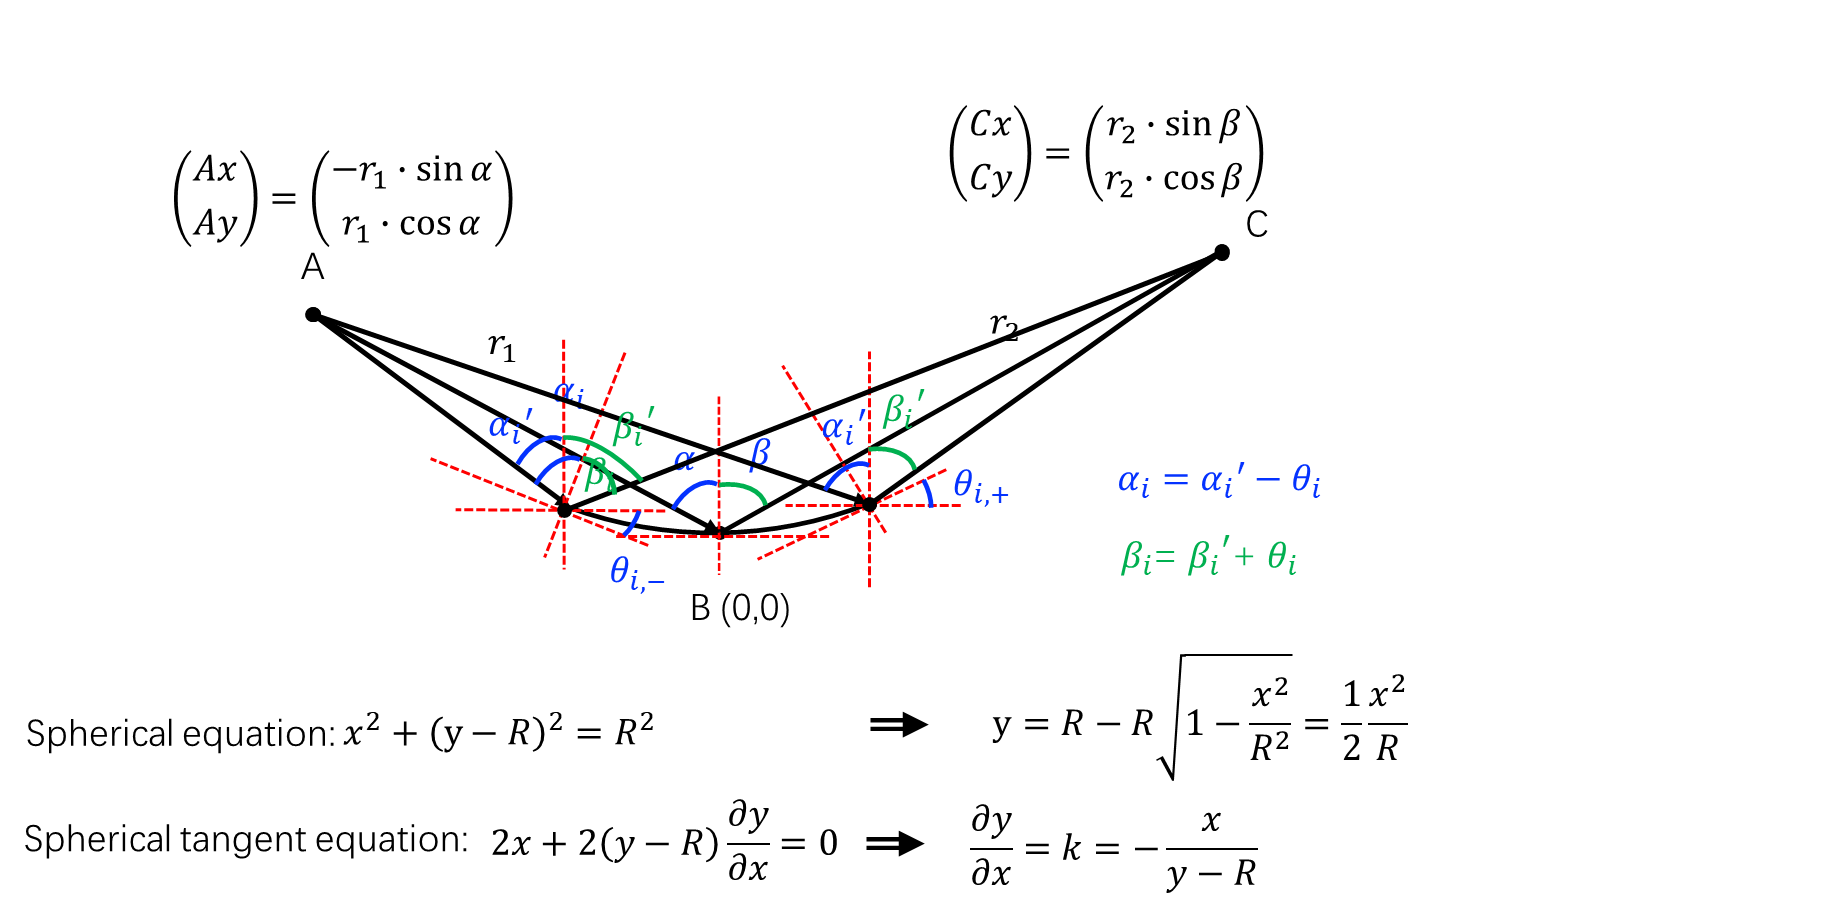

In [1]:
# Spherical
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clr
from scipy.optimize import fsolve

# function used to calculate the intersection between the incoming rays and spherical surface 
# Since the development of the nonlinear solving methods, the precise intersection can be obtain without Taylor's expansion approximation
def func_cross_FM_after_Taylor_expansion(x):
    return [ temp_k_in * (x[0] - OA_point[0]) + OA_point[1] - x[1],
             1/2*pow(x[0],2)/R - x[1]  ]

def func_cross_FM(x):
    return [ temp_k_in * (x[0] - OA_point[0]) + OA_point[1] - x[1],
             R - R*np.sqrt(1-pow(x[0]/R,2)) - x[1]  ]

# Grating equation 
def chief_ray_beta_rad_calc(a0_mm, diffraction_order, wavelength_mm, chief_ray_alpha_rad):
    return  np.arcsin( a0_mm * diffraction_order * wavelength_mm + np.sin(chief_ray_alpha_rad) )
    
## input parameters for a VLS-PG
a0_mm = 2400               # central line density of a grating; unit [mm]
diffraction_order = -1     # aligne with definination of SHADOW
energy = 400               # optimal photon energy; unit [eV]
hc = 1.23984193e-3         # constant value for converting the unit of eV to that of wavelength, and vice-versa ; unit [eV*mm]
r1 = 795.9                  # incoming length r1; unit [mm]
r2 = 3288.1                # outgoing length r2; unit [mm]
chief_ray_alpha_deg = 87.2       # incident alpha; unit [deg.]
CCD_tilt_gamma_deg = 20    # tilt angle of CCD detector for a RIXS spectrometer; unit [deg.]

## convert the unit for adapting with python function
wavelength_mm = hc/energy                          # convert photon energy from [eV] to [mm]
chief_ray_alpha_rad = chief_ray_alpha_deg/180*np.pi    # convert [deg.] to [rad] . 
CCD_tilt_gamma_rad = CCD_tilt_gamma_deg/180*np.pi  # convert [deg.] to [rad] . 

## Calculate the diffraction angle beta for the chief ray
chief_ray_beta_rad = chief_ray_beta_rad_calc(a0_mm, diffraction_order, wavelength_mm, chief_ray_alpha_rad) 
chief_ray_include_anlge_deg = chief_ray_alpha_deg + chief_ray_beta_rad/np.pi*180 #

## Calculate the radius of a VLS-SG for RIXS spectrometer
SG_R_calc_topT = - (np.cos(chief_ray_alpha_rad) + np.cos(chief_ray_beta_rad) + np.tan(chief_ray_beta_rad) * diffraction_order * wavelength_mm * a0_mm)
SG_R_calc_botT = diffraction_order * wavelength_mm * a0_mm/ r2* (np.cos(chief_ray_beta_rad) / np.tan(CCD_tilt_gamma_rad)-2 * np.sin(chief_ray_beta_rad))-(np.cos(chief_ray_alpha_rad)**2 / r1 + np.cos(chief_ray_beta_rad)**2/r2) 
SG_R = SG_R_calc_topT / SG_R_calc_botT
R = SG_R
print("r1 = "+str(r1)+" mm",
      "\nr2 = "+str(r2)+" mm",
      "\nenergy = "+str(energy)+" eV",
      "\na0_mm= "+str(a0_mm)+" lines/mm-1",
      "\nCCD_tilt_gamma_deg = "+str(CCD_tilt_gamma_deg)+" deg.",
      "\nbeta = "+str(chief_ray_beta_rad/np.pi*180)+" deg.",
      "\ninclude angle = "+str(chief_ray_include_anlge_deg)+" deg.",
      "\nSG_R = "+str(SG_R)+" mm"+"\n")      


r1 = 795.9 mm 
r2 = 3288.1 mm 
energy = 400 eV 
a0_mm= 2400 lines/mm-1 
CCD_tilt_gamma_deg = 20 deg. 
beta = 82.46593652624586 deg. 
include angle = 169.66593652624584 deg. 
SG_R = 27156.18669535969 mm



Text(700, -10, 'VLS-CG')

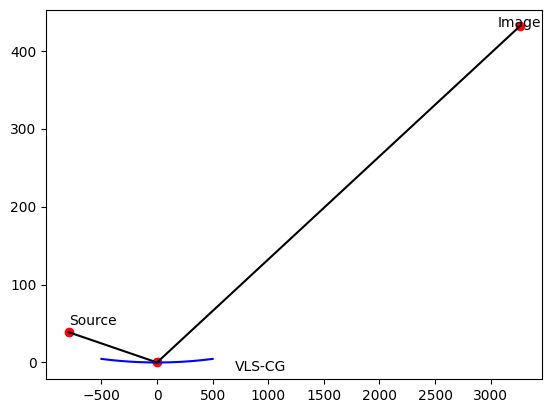

In [2]:
# upon the aforementioned parameters, a optical layout can be constructed by the chief ray pathing through source point, VLS-G center point, and image point
OA_point = [-r1*np.sin(chief_ray_alpha_rad),r1*np.cos(chief_ray_alpha_rad)]
OB_point = [0,0]
OC_point = [r2*np.sin(chief_ray_beta_rad),r2*np.cos(chief_ray_beta_rad)]

# draw the cylindrical profile of a VLS-SG 
sphere_plot_x = np.linspace(-500,500,101)
sphere_plot_y2 = -np.sqrt( pow(SG_R,2) - pow(sphere_plot_x,2) ) + SG_R

plt.plot(sphere_plot_x,sphere_plot_y2,'b')
plt.scatter(OA_point[0],OA_point[1],color = 'red')
plt.scatter(OB_point[0],OB_point[1],color = 'red')
plt.scatter(OC_point[0],OC_point[1],color = 'red')
plt.plot([OA_point[0],OB_point[0],OC_point[0]],[OA_point[1],OB_point[1],OC_point[1]],color ='black')
#plt.ylim([-OA_point[1],OA_point[1]*10])

plt.text(OA_point[0],OA_point[1]+10,'Source')
plt.text(OC_point[0]-200,OC_point[1],'Image')
plt.text(OB_point[0]+700,OB_point[1]-10,'VLS-CG')


Gooves parameter for plane VLS grating
a0_mm= 2400.000000000008 
a1 = 0.516043597298922 
a2 = -0.00067164539749783 
a3 = 1.5814126928468048e-06 
a4 = -2.3068914114668385e-09
[-5.13649587e-15  3.56086708e-12 -2.30689141e-09  1.58141269e-06
 -6.71645397e-04  5.16043597e-01  2.40000000e+03]
87.12711631034792 82.47330731547129 87.26409131001654 82.45605895352891


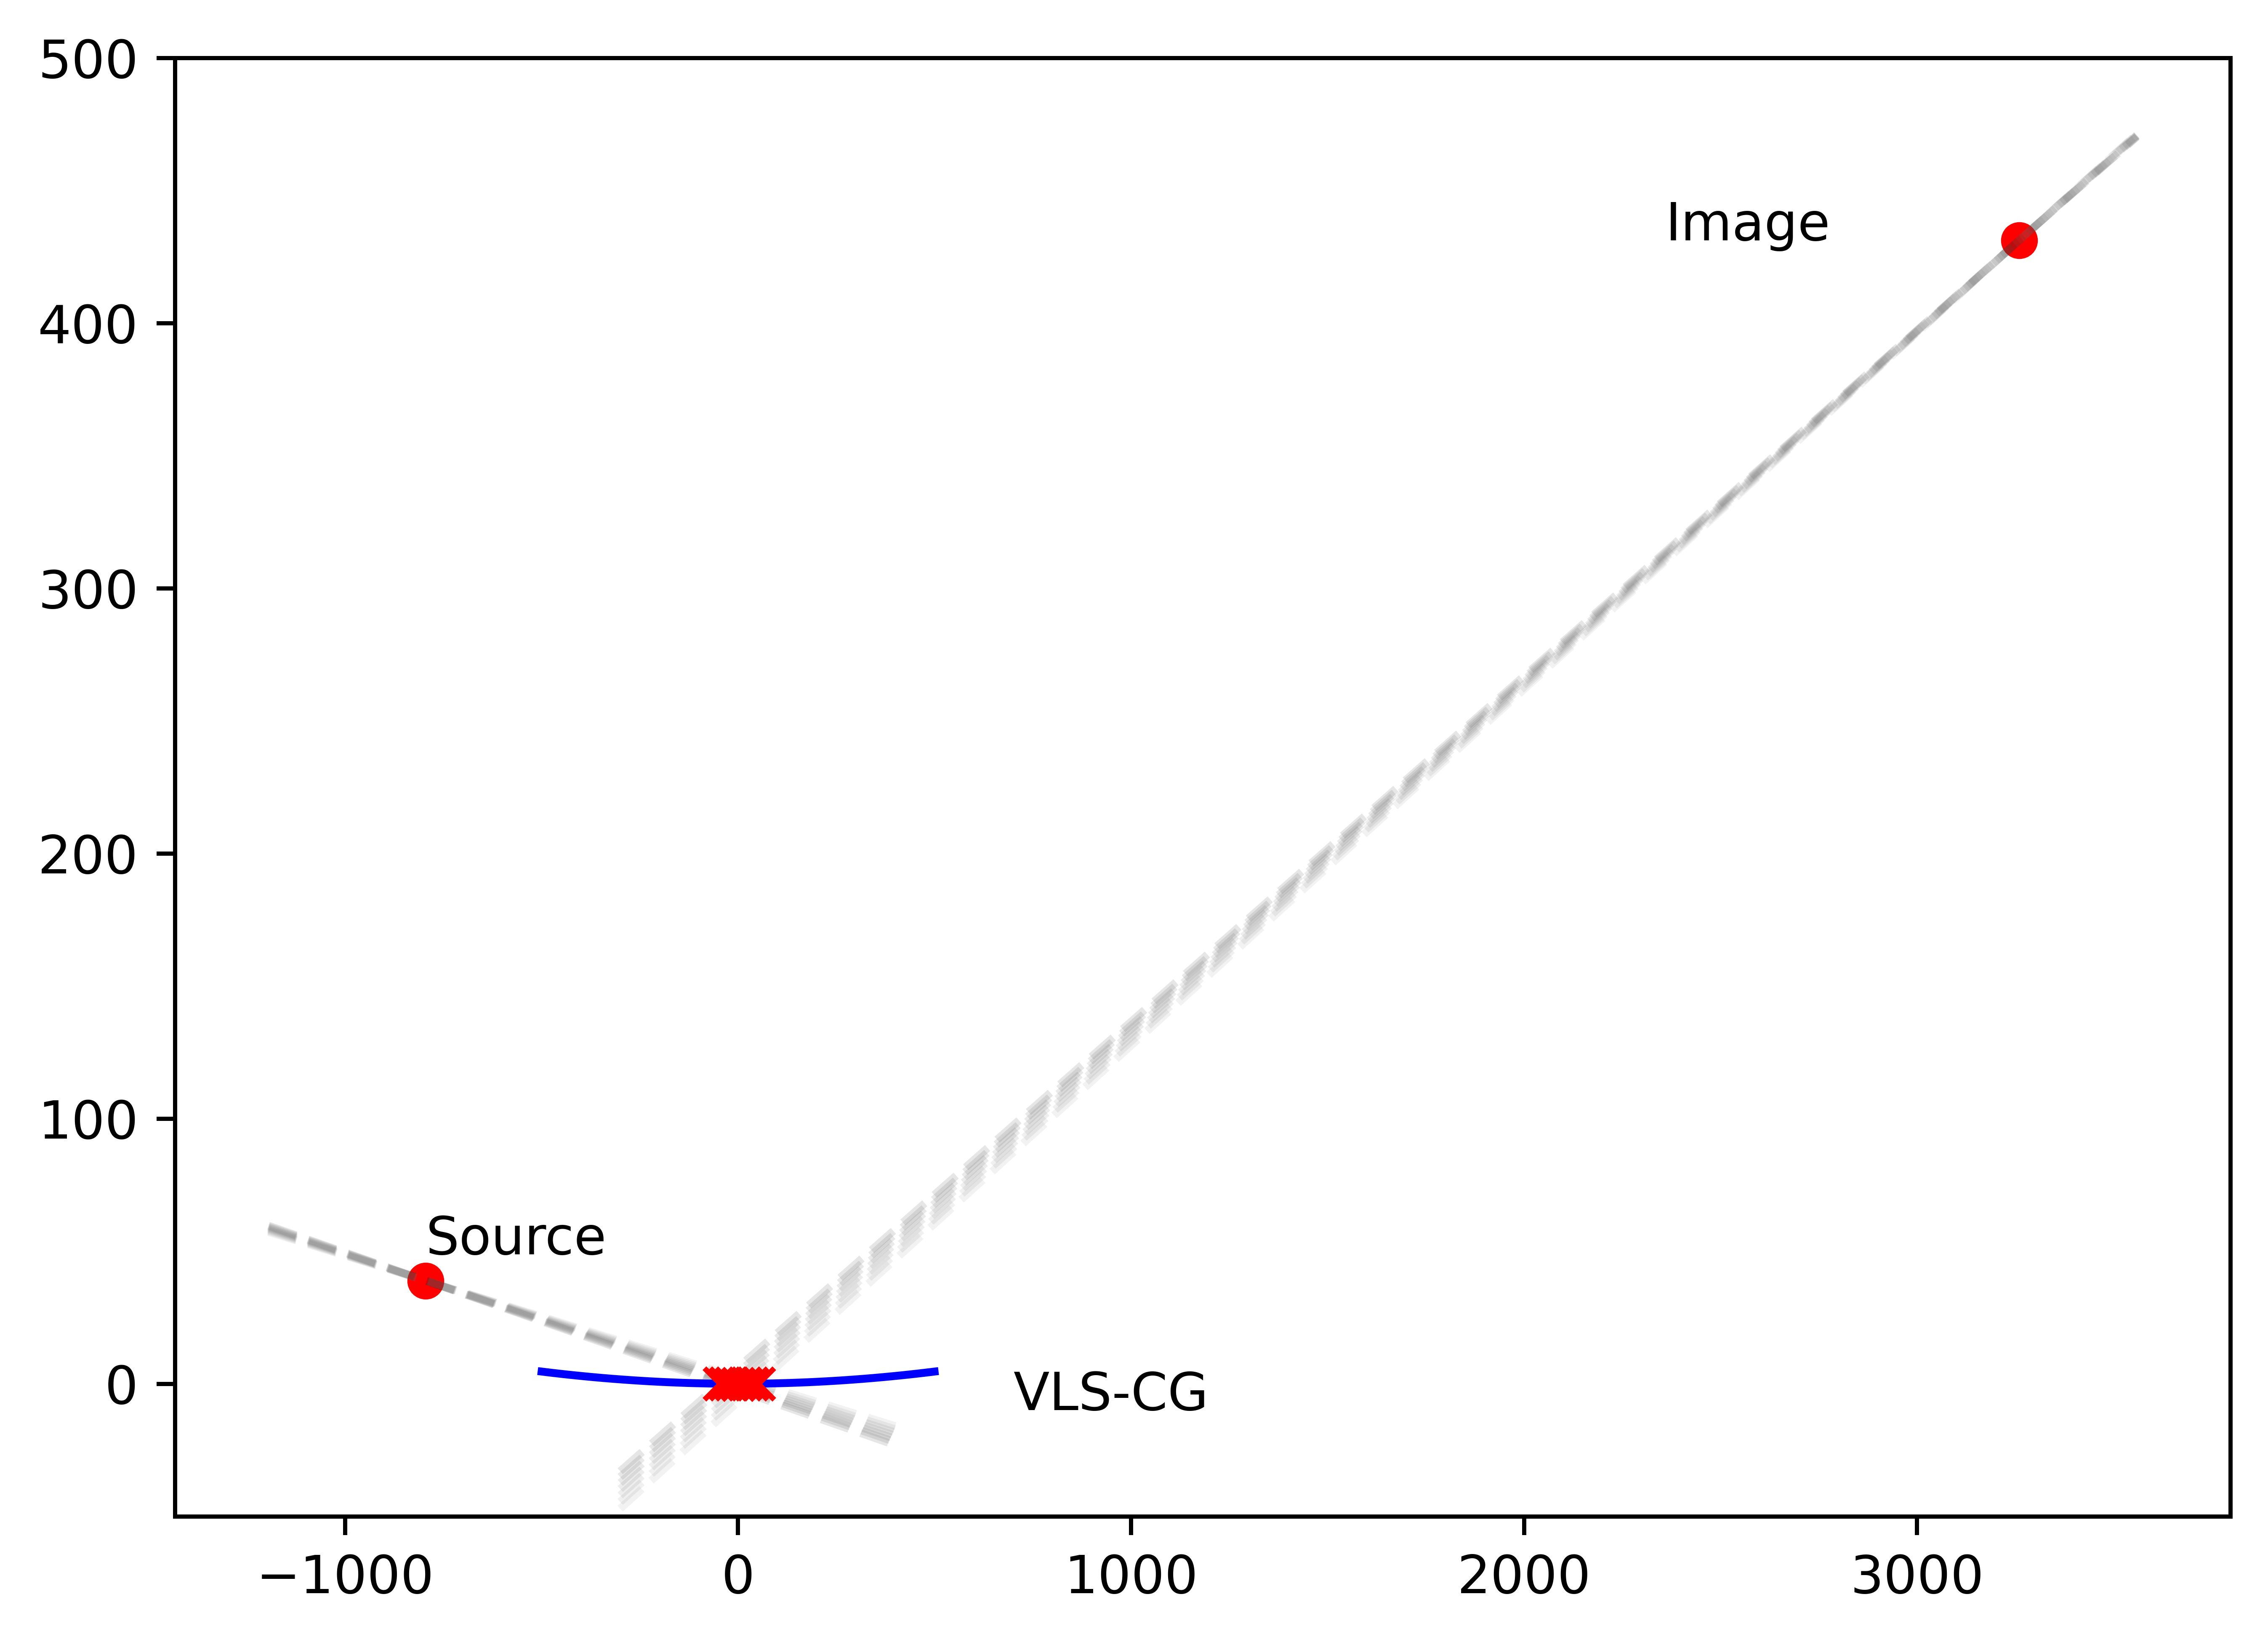

In [3]:
# ray tracing process
# first, define the dispersive angle for a source ; it relates to the numerical aperture of a VLS-SG
dk_accept = np.linspace(-np.tan(3*1e-3),np.tan(3*1e-3),7) # introducing number rays of 7
k_chief_in = OA_point[1]/OA_point[0]                      # the vector of incoming ray for the chief ray
k_in = dk_accept + k_chief_in                             # the vector arrays for the incoming rays

local_alpha = np.zeros(np.size(k_in)) 
local_beta = np.zeros(np.size(k_in))
local_a = np.zeros(np.size(k_in))
local_w = np.zeros(np.size(k_in))
local_w2 = np.zeros(np.size(k_in))
local_include_angle =  np.zeros(np.size(k_in))
SG_cross_points_array = np.zeros([np.size(k_in),2])

# plot incoming rays alonging x axis
line_k_in_x = np.linspace(OA_point[0]-400,OB_point[0]+400,3)

fig = plt.figure(dpi=900,figsize=(7,5))

# tracing 7 rays with a dispersive angle relative to the chief ray
for n_line in np.arange(0,np.size(dk_accept)):
    rlt_cross_FM = np.zeros(2)
    temp_k_in = k_in[n_line]

    # solving the intersection between the incoming rays and the VLS-SG surface
    rlt_cross_FM = fsolve(func_cross_FM, [OB_point[0], OB_point[1]])

    # save the intersection points
    SG_cross_points_array[n_line,:] = rlt_cross_FM

    # draw incoming rays individual that emits from source point OA
    line_k_in_y = temp_k_in*(line_k_in_x - OA_point[0]) + OA_point[1]
    plt.plot(line_k_in_x,line_k_in_y,'--',color = str((n_line+1)/(2*np.size(dk_accept))), alpha = 0.1 )#"C"+str(n_line))

    # Given the expression of cylindrical equations, whose tangent function can be obtained from the partial division of x for the cylindrical equations.  
    tg_k_in = -1/(rlt_cross_FM[1]-SG_R)*rlt_cross_FM[0]

    # draw tangent line for the intersections with a range around VLS-SG central point OB
    tg_k_in_x = np.linspace(OB_point[0]-200,OB_point[0]+200,3)
    tg_k_in_y = tg_k_in*(tg_k_in_x - rlt_cross_FM[0]) + rlt_cross_FM[1]

    # calculate local incident angle ; Note that the incident angle is always defined as the angle between the incoming ray and the local normal direction. 
    # there is one way to calculate ; A general expression can be used to calculate the adjacent angle based on two vectors  (strongly recommanded).
    local_alpha[n_line] = (90+np.arctan(temp_k_in)/np.pi*180 - np.arctan(tg_k_in)/np.pi*180)

    # Once the intersection 'rlt_cross_FM' is obtained, the diffraction rays that are focused at the same image point can be described using a coordinate relationship.
    diff_k = (OC_point[1]-rlt_cross_FM[1])/(OC_point[0]-rlt_cross_FM[0])    

    # calculate local diffraction angle ; Note that the diffraction angle is always defined as the angle between the outgoing ray and the local normal direction. 
    # there is one way to calculate ; A general expression can be used to calculate the adjacent angle based on two vectors (strongly recommanded).
    local_beta[n_line] = 90 -(np.arctan(diff_k) -np.arctan(tg_k_in))/np.pi*180

    # once the incident angle and diffraction angle are calculated, the local line density can be calculated using grating equation (similar form as Brrag diffraction)
    local_a[n_line] = (np.sin(local_beta[n_line]/180*np.pi) - np.sin(local_alpha[n_line]/180*np.pi)) /wavelength_mm/diffraction_order

    # Note that VLS-G have groove direction, it is along with beam propagation
    if OB_point[0] >= rlt_cross_FM[0]:
        local_w[n_line] = -np.linalg.norm(OB_point - rlt_cross_FM)        
    else:
        local_w[n_line] = np.linalg.norm(OB_point - rlt_cross_FM)

    # draw the diffraction rays
    diff_k_x =  np.linspace(OB_point[0]-300, OC_point[0]+300,3)
    diff_k_y = diff_k*(diff_k_x - rlt_cross_FM[0]) + rlt_cross_FM[1]
    plt.plot(diff_k_x,diff_k_y,'--',color = str((n_line+1)/(2*np.size(dk_accept))) , alpha = 0.1)#

    # extract two marginal rays (left and right)
    if n_line == 0:
        left_cross_point = rlt_cross_FM
    if n_line == np.size(dk_accept)-1:
        right_cross_point = rlt_cross_FM
        
# draw 7 lines of ray tracing 
plt.plot(sphere_plot_x,sphere_plot_y2,'b')
plt.scatter(OA_point[0],OA_point[1],color = 'red')
plt.scatter(OC_point[0],OC_point[1],color = 'red')
plt.plot(SG_cross_points_array[:,0],SG_cross_points_array[:,1],'rx')
plt.ylim([-OA_point[1],OA_point[1]*10])

plt.text(OA_point[0],OA_point[1]+10,'Source')
plt.text(OC_point[0]-900,OC_point[1],'Image')
plt.text(OB_point[0]+700,OB_point[1]-10,'VLS-CG')

#plt.xlim([-200,200])
plt.ylim([-50,500])
a_array = np.polyfit(local_w,local_a,6)
print("Gooves parameter for plane VLS grating\n"+
      "a0_mm=",a_array[-1],"\n"+
      "a1 =",a_array[-2],"\n"+
      "a2 =",a_array[-3],"\n"+
      "a3 =",a_array[-4],"\n"+
      "a4 =",a_array[-5])
print(a_array)
print(local_alpha[0],local_beta[0],local_alpha[-1],local_beta[-1])
plt.show()


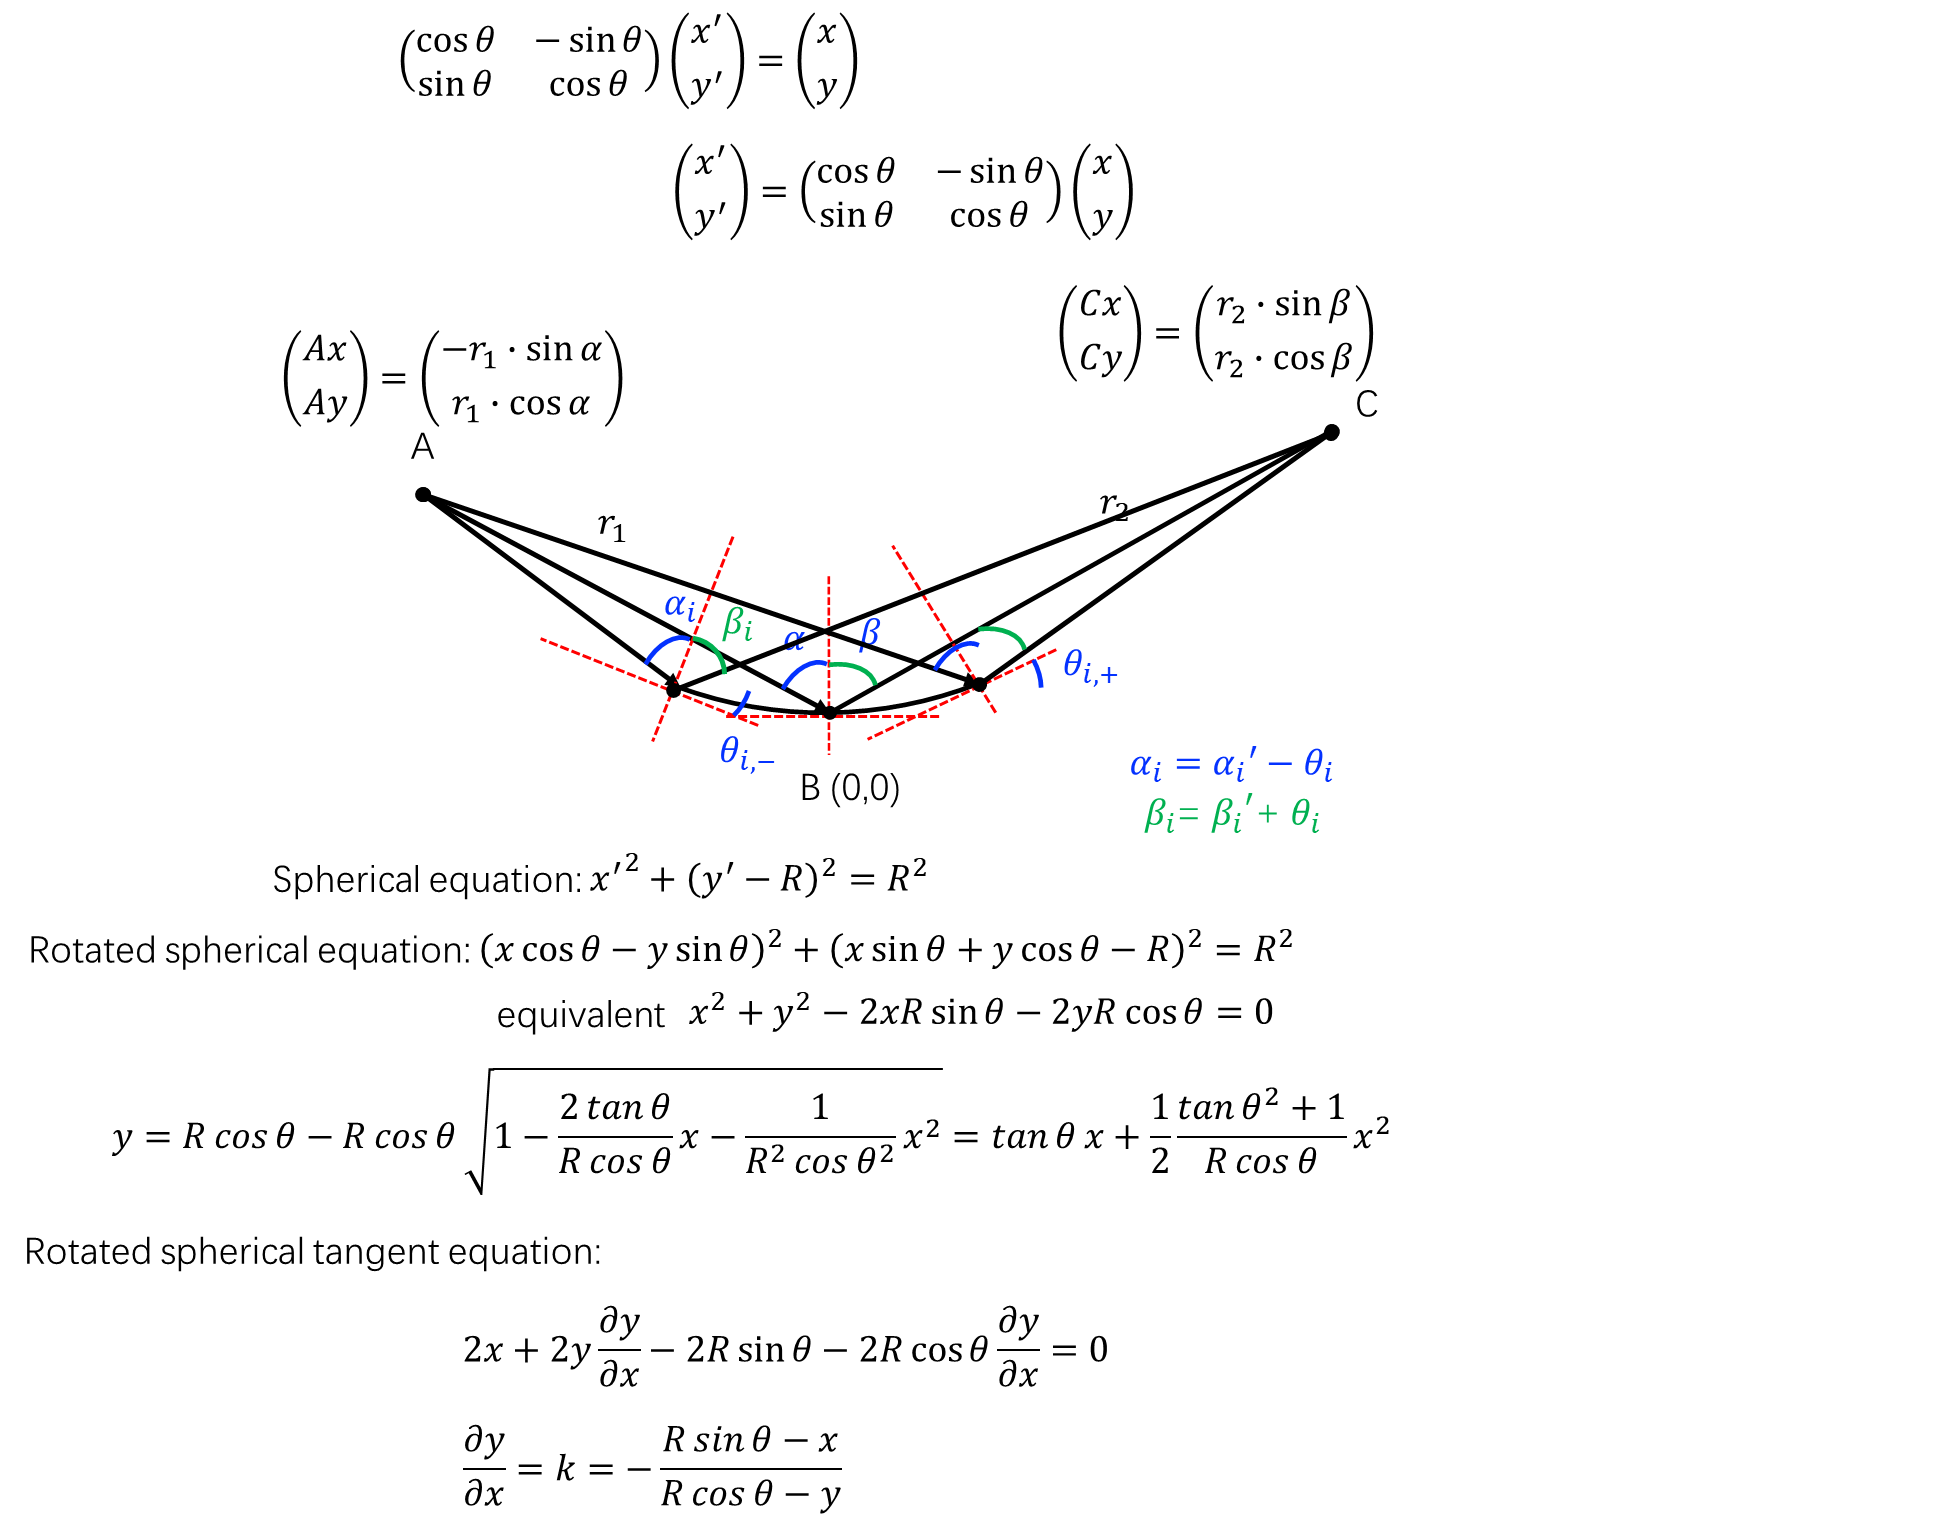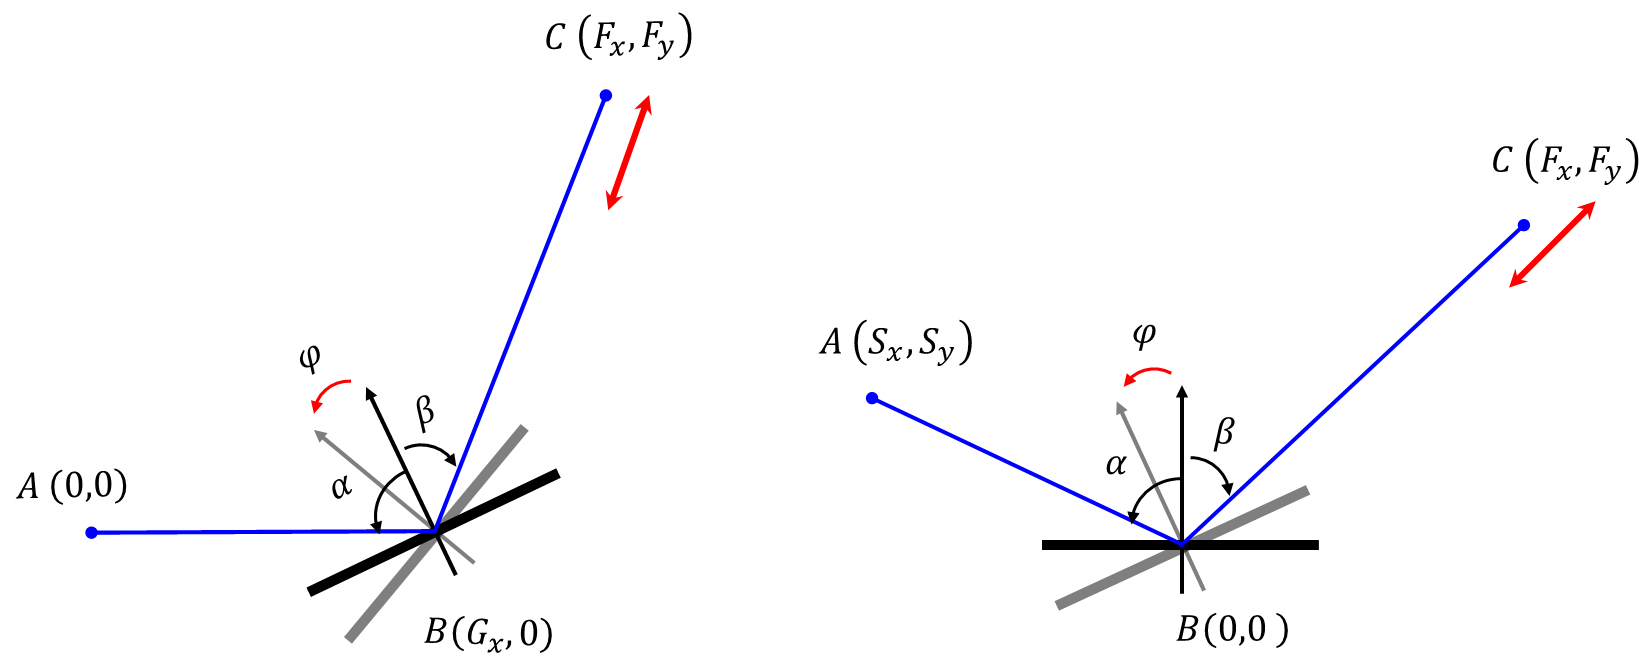

===== CPU info =====
CPU type: Intel(R) Core(TM) i9-14900HX
archtecture: X86_64
bits: 64
Core number physic: 24
Core number logical: 32
Current CPU frequency (MHz): 2200.0
Maximum CPU frequency (MHz): 2200.0

===== Results =====
Time total: 18.531838 s
Time each point: 0.012184 s
Initial CPU using rate: 8.6%
End CPU using rate: 5.5%
Peak memory usage: 220.12 MB
[930] [87.2] [987.43495016] [2492.28971602]


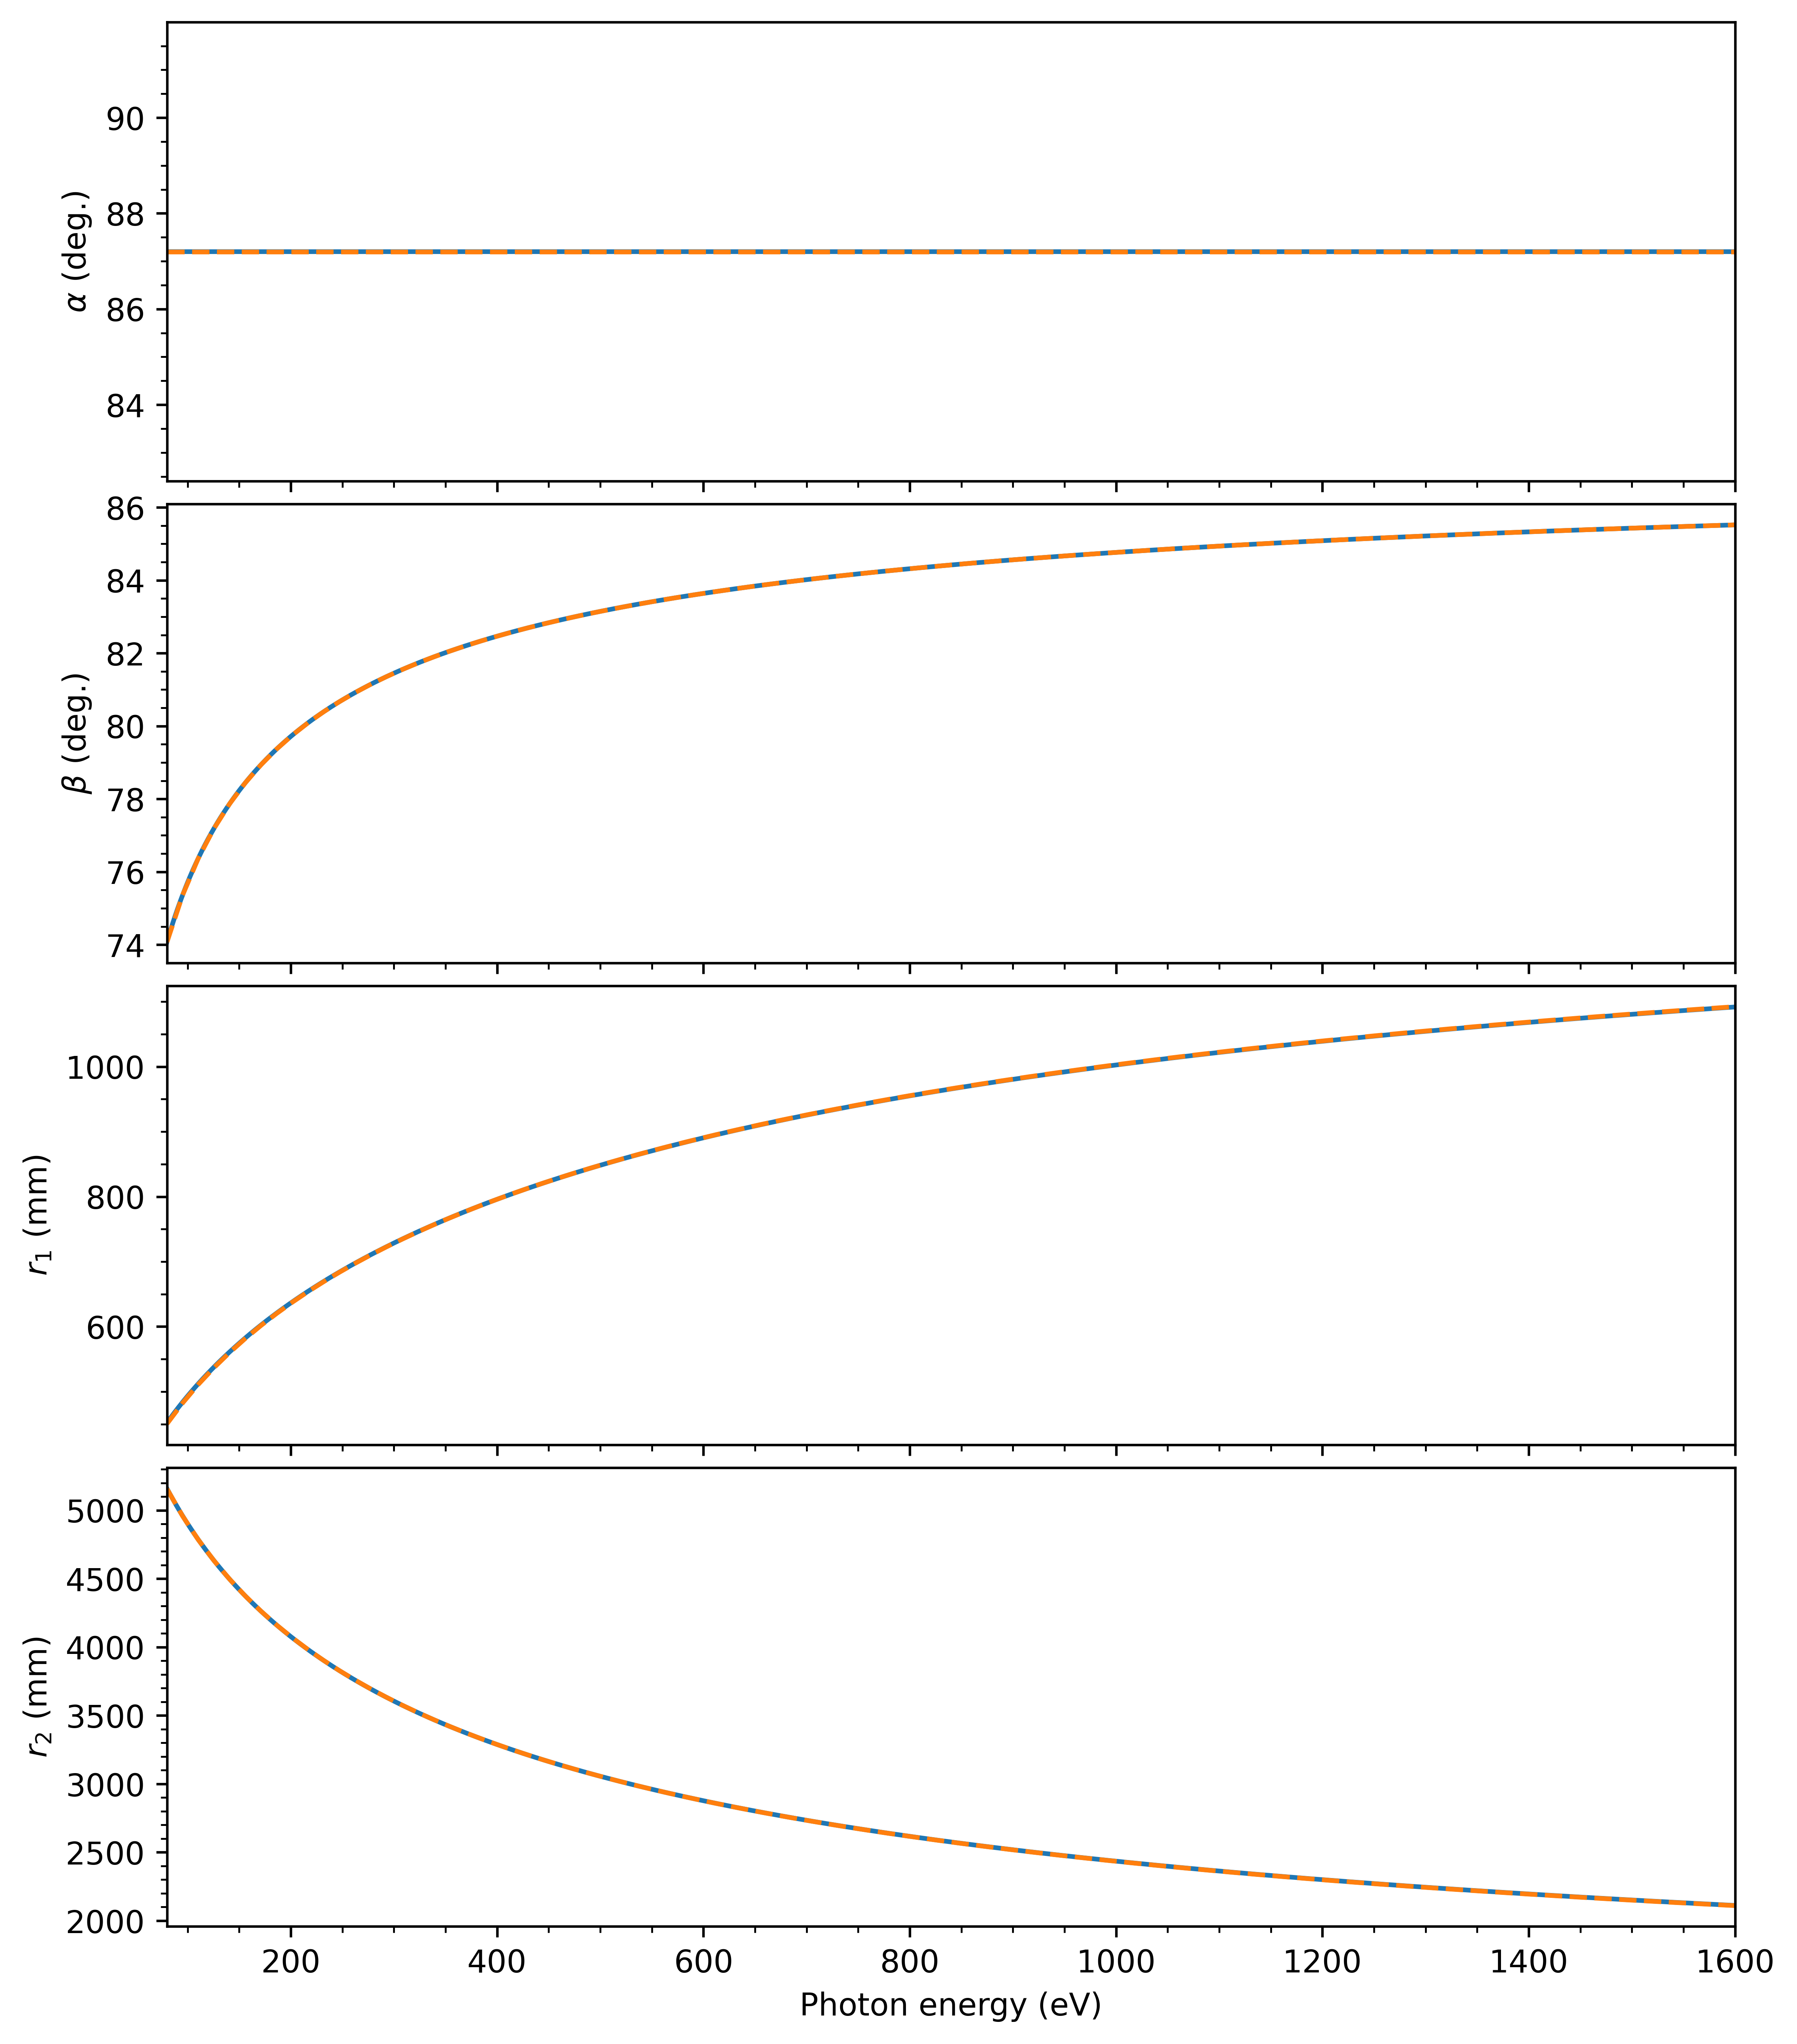

In [4]:
# ===== note and a "stupid" idea and working on generalization ====== #
# To generalize the normal vector description, I propose starting with mesh grid matrix data to represent the mirror surface (but computational time increases a lot). 
# Based on the mesh grid matrix, it easy to achieve the local normal vector 
# Even without the mathematic description of a surface, the intersections between the incoming rays and surface are still calculable using finite-element-method idea.
# While intersections' calculations lose analytical accuracy due to discretization, reducing the mesh size allows us to:
# 1. Define the minimum spatial resolution threshold for instrumentation.
# 2. Establish manufacturing accuracy requirements.

import time
import psutil  # if necessary: pip install psutil
import cpuinfo  # if necessary：pip install py-cpuinfo

# since VLS-SG have 3 variables including alpha, arm-in, and arm-out, it needs 3 equations (a1,a2,and a3) to solve.
# Using ray tracing method, two marginal rays relationship are evident (e.g., source\intersection\focal position formed triangle = included angle ). 
# Third equations could be artifically given for instance, fixing alpha\incoming length\outgoing length\total length and etc.    

# case 1 fixed alpha as optimized value
import matplotlib.ticker as tck
def get_cpu_info():
    """Get CPU info """
    info = cpuinfo.get_cpu_info()
    return {
        "CPU type": info.get("brand_raw", "未知"),
        "archtecture": info.get("arch", "未知"),
        "bits": info.get("bits", "未知"),
        "Core number physic": psutil.cpu_count(logical=False),
        "Core number logical": psutil.cpu_count(logical=True),
        "Current CPU frequency (MHz)": psutil.cpu_freq().current if psutil.cpu_freq() else "未知",
        "Maximum CPU frequency (MHz)": psutil.cpu_freq().max if psutil.cpu_freq() else "未知",
    }
    
cpu_info = get_cpu_info()
print("===== CPU info =====")
for key, value in cpu_info.items():
    print(f"{key}: {value}")

# record initial CPU using rate and time
start_time = time.time()
cpu_percent_before = psutil.cpu_percent(interval=0.5)  # initial CPU taking rate （sampling 0.5s）

# giving cylindrical VLS-G radius center position
SG_center_point = [0,SG_R]
hc = 1.23984193e-3  
wavelength_mm = hc/930
def find_focus_p(variables):
    # describe rotated cylindrical surface with variables
    def SG_curve(temp_theta,x):
        return SG_R*np.cos(temp_theta) - SG_R*np.cos(temp_theta)*np.sqrt(1 - 2*np.tan(temp_theta)/SG_R/np.cos(temp_theta)*x - pow(x/(SG_R*np.cos(temp_theta)),2) ) 

    # defination variables
    (temp_theta,arm_in,arm_out) = variables

    # source position 
    arm_in_x = OA_point[0]/r1*arm_in
    arm_in_y = OA_point[1]/r1*arm_in
    moved_OA_point = [arm_in_x, arm_in_y]

    # rotation matrix used to rotate the VLS-G with a varaible of theta 
    rot_matrix = [[np.cos(temp_theta), - np.sin(temp_theta)],[np.sin(temp_theta),np.cos(temp_theta)]]
    # The center of VLS-G cylind after rotation with a variables of theta
    Roted_SG_center_point = np.matmul(rot_matrix,SG_center_point)

    # marginal points after rotation for x axis 
    temp_position_left_x = np.matmul(rot_matrix,[local_w[0],0])
    temp_position_right_x = np.matmul(rot_matrix,[local_w[-1],0])

    # marginal points after rotation (meaning that the primary length of grating are always illuminated by incoming rays)
    left_cross_SG = [temp_position_left_x[0],SG_curve(temp_theta,temp_position_left_x[0])]
    right_cross_SG = [temp_position_right_x[0],SG_curve(temp_theta,temp_position_right_x[0])]


    # chief rays
    vec_k1_chief = [OB_point[0]-moved_OA_point[0],OB_point[1]-moved_OA_point[1]]  # incoming ray vector 
        # local normal vector. For a circle, the line passing through the center and any point on the circumference is perpendicular to the local tangent line at that point.
    vec_k2_chief_norm = [OB_point[0]-Roted_SG_center_point[0],OB_point[1]-Roted_SG_center_point[1]] # local normal vector (specific case of circle)
        # using vectors (the vector of incoming ray and the normal vector at intersection points) to calculate the alpha angle 
    chief_alpha_in_rad = np.arccos( np.matmul(vec_k1_chief,vec_k2_chief_norm) /(np.linalg.norm(vec_k1_chief)*np.linalg.norm(vec_k2_chief_norm))  )   

    #left marginal ray (similar to the chief ray)
    vec_k1_left = [left_cross_SG[0]-moved_OA_point[0],left_cross_SG[1]-moved_OA_point[1]]
    vec_k2_left_norm = left_cross_SG - Roted_SG_center_point
    left_alpha_in_rad = np.arccos( np.matmul(vec_k1_left,vec_k2_left_norm) /(np.linalg.norm(vec_k1_left)*np.linalg.norm(vec_k2_left_norm))  ) 
   
    # right marginal ray (similar to the chief ray)
    vec_k1_right =  [right_cross_SG[0]-moved_OA_point[0],right_cross_SG[1]-moved_OA_point[1]]
    vec_k2_right_norm = right_cross_SG - Roted_SG_center_point
    right_alpha_in_rad = np.arccos( np.matmul(vec_k1_right,vec_k2_right_norm) /(np.linalg.norm(vec_k1_right)*np.linalg.norm(vec_k2_right_norm))  )    

    # local line density (using rotation treating with grating position makes it easier to follow the local line density)
    left_a_w = np.polyval(a_array,left_cross_SG[0]) # a_array are found in abovementioned code
    right_a_w = np.polyval(a_array,right_cross_SG[0])
    chief_a_w = np.polyval(a_array,0)

    # using grating equation to calculate diffraction angle
    chief_beta_out_rad = np.arcsin(chief_a_w * diffraction_order * wavelength_mm + np.sin(chief_alpha_in_rad) )
    left_beta_out_rad = np.arcsin( left_a_w * diffraction_order * wavelength_mm + np.sin(left_alpha_in_rad) )
    right_beta_out_rad = np.arcsin( right_a_w * diffraction_order * wavelength_mm + np.sin(right_alpha_in_rad) ) 

    # calculate diffraction ray tange (k) used to describe the focal position of others photon energies
    diff_k_chief = np.tan( np.pi/2 - chief_beta_out_rad + np.arctan(-(OB_point[0] - Roted_SG_center_point[0])/(OB_point[1] - Roted_SG_center_point[1])))

    # calculate the focal position of others photon energies
    arm_out_x = arm_out*np.cos(np.arctan(diff_k_chief))
    arm_out_y = arm_out*np.sin(np.arctan(diff_k_chief))

    # Three constraint conditions used to solve three variables 
    Eqn_1 = temp_theta
    Eqn_2 = (left_beta_out_rad + left_alpha_in_rad) - np.arccos( np.matmul([left_cross_SG[0]-arm_in_x,left_cross_SG[1]-arm_in_y],[left_cross_SG[0]-arm_out_x,left_cross_SG[1]-arm_out_y]) /(np.linalg.norm([left_cross_SG[0]-arm_in_x,left_cross_SG[1]-arm_in_y])*np.linalg.norm([left_cross_SG[0]-arm_out_x,left_cross_SG[1]-arm_out_y])))
    Eqn_3 = (right_beta_out_rad + right_alpha_in_rad) - np.arccos( np.matmul([right_cross_SG[0]-arm_in_x,right_cross_SG[1]-arm_in_y],[right_cross_SG[0]-arm_out_x,right_cross_SG[1]-arm_out_y]) /(np.linalg.norm([right_cross_SG[0]-arm_in_x,right_cross_SG[1]-arm_in_y])*np.linalg.norm([right_cross_SG[0]-arm_out_x,right_cross_SG[1]-arm_out_y])))

    return [Eqn_1,Eqn_2,Eqn_3]
    
# inital set for calculating focal position from Emin to Emax 
hc = 1.2398e-3  #eV*mm
start_energy = 80
end_energy = 1600
step_energy = 1
number_energy = int((end_energy-start_energy)/step_energy +1 )
energy_array = np.arange(start_energy,end_energy,step_energy)
alpha_chief_array = np.zeros(len(energy_array))
beta_chief_array = np.zeros(len(energy_array))
arm_in_array = np.zeros(len(energy_array))
arm_out_array = np.zeros(len(energy_array))

rotate_angle_array = np.zeros(len(energy_array))

#value_VLS_theta_array = np.linspace(start_energy,end_energy,number_energy)

# calculate photon energy dependent focal positions
k = 0
for energy in energy_array:
    wavelength_mm = hc/energy
    data = fsolve(find_focus_p,[0/180*np.pi,r1,r2]) 
    alpha_chief = chief_ray_alpha_deg- data[0]/np.pi*180
    alpha_chief_array[k] = alpha_chief
    beta_chief_array[k] = np.arcsin(a0_mm* diffraction_order * wavelength_mm + np.sin(alpha_chief/180*np.pi) )/np.pi*180
    rotate_angle_array[k] = data[0]/np.pi*180
    arm_in_array[k] = data[1]
    arm_out_array[k] = data[2]
    k += 1

# CPU state
end_time = time.time()
cpu_percent_after = psutil.cpu_percent(interval=0.5)  # 结束 CPU 占用率（采样 0.5s）
memory_usage = psutil.Process().memory_info().rss / (1024 ** 2)  # 内存占用（MB）
    
# CPU info output
print("\n===== Results =====")
print(f"Time total: {end_time - start_time:.6f} s")
print(f"Time each point: {(end_time - start_time)/number_energy:.6f} s")


print(f"Initial CPU using rate: {cpu_percent_before}%")
print(f"End CPU using rate: {cpu_percent_after}%")
print(f"Peak memory usage: {memory_usage:.2f} MB")

#Plot results from ray-tracing and compared with the results derived from the light path function under Fermat's principle
fig, (ax1,ax2,ax3,ax4)= plt.subplots(4,sharex=True,dpi=600,figsize=(9,11))
plt.subplots_adjust(hspace = 0.05)

ax1.plot(energy_array,alpha_chief_array)
ax1.set_xlim([start_energy,end_energy])
ax1.set_ylabel(r'$\alpha$ (deg.)')
ax1.yaxis.set_minor_locator(tck.AutoMinorLocator())
ax1.xaxis.set_minor_locator(tck.AutoMinorLocator())

ax2.plot(energy_array,beta_chief_array)
ax2.set_ylabel(r'$\beta$ (deg.)')
ax2.tick_params(axis='y')
ax2.set_xlim([start_energy,end_energy])
ax2.yaxis.set_minor_locator(tck.AutoMinorLocator())

ax3.plot(energy_array,arm_in_array)
ax3.set_ylabel(r'$r_1$ (mm)')
ax3.yaxis.set_minor_locator(tck.AutoMinorLocator())

ax4.plot(energy_array,arm_out_array)
ax4.set_ylabel(r'$r_2$ (mm)')
ax4.set_xlabel(r'Photon energy (eV)')
ax4.yaxis.set_minor_locator(tck.AutoMinorLocator())

import pandas as pd
#df_Fixe_alpha = pd.read_excel(r'Fixe_r2_sort_data.xls',header=None)
#df_Fixe_alpha = pd.read_excel(r'FreeAberration_sort_data.xls',header=None)
#df_Fixe_alpha = pd.read_excel(r'Fixe_alpha_sort_data.xls',header=None)

# Load the Excel file
df = pd.read_excel('LPF_data_fixe_alpha.xlsx')

# draw data from LPF 
ax1.plot(df['Energy'].values,df['Alpha_LPF_focal'].values,'--')
ax2.plot(df['Energy'].values,df['Beta_LPF_focal'].values,'--')
ax3.plot(df['Energy'].values,df['r1_LPF_focal'].values,'--')
ax4.plot(df['Energy'].values,df['r2_LPF_focal'].values,'--')

print_index = np.where(energy_array ==930)
print(energy_array[print_index],alpha_chief_array[print_index],arm_in_array[print_index],arm_out_array[print_index])

#plt.savefig('energy_dependent_focus_movement_fixed_alpha.jpg')

In [5]:
print(r1,r2)

795.9 3288.1
